In [1]:
#Configuramos un poco el colab
!pip install --upgrade spacy
!python -m spacy download es_core_news_sm
!pip install spacymoji

     |████████████████████████████████| 6.0 MB 896 kB/s 
     |████████████████████████████████| 628 kB 40.4 MB/s 
     |████████████████████████████████| 181 kB 45.8 MB/s 
  Attempting uninstall: thinc
    Found existing installation: thinc 8.0.11
    Uninstalling thinc-8.0.11:
      Successfully uninstalled thinc-8.0.11
  Attempting uninstall: spacy
    Found existing installation: spacy 3.1.3
    Uninstalling spacy-3.1.3:
      Successfully uninstalled spacy-3.1.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
en-core-web-sm 3.1.0 requires spacy<3.2.0,>=3.1.0, but you have spacy 3.2.0 which is incompatible.
en-core-web-lg 3.1.0 requires spacy<3.2.0,>=3.1.0, but you have spacy 3.2.0 which is incompatible.
allennlp 2.7.0 requires spacy<3.2,>=2.1.0, but you have spacy 3.2.0 which is incompatible.
     |████████████████████████████████| 14.0 MB 6.8 MB/s 
✔ Down

In [2]:
import spacy
from spacy import Language
import spacymoji
import pandas as pd
from collections import Counter, OrderedDict
from spacy.tokens import Token
import re
import random

#Creamos el componente que detecta tokens repetidos en secuencia
Token.set_extension("repeated", default=False, force=True)
@Language.component("mark_repeats")
def delete_emojis(doc):
  for token in doc[:-1]:
    if token.text == doc[token.i+1].text:
      token._.repeated = True
  return doc

nlp = spacy.load("es_core_news_sm")

#agregamos los detectores
nlp.add_pipe("emoji", first=True)
nlp.add_pipe("mark_repeats", last=True)

#leemos la base de datos
df = pd.read_csv("../input/vacunas/dataset_pln_20211019.csv", dtype=str)

#Preprocesamos un poco el texto
df["tweets"] = df["full_text"]
#df["tweets"] = df["tweets"].str.lower()

#sacamos errores comunes observadoes en los token
df["tweets"] = df["tweets"].str.replace("\u200d", "")
df["tweets"] = df["tweets"].str.replace("unroll", "")


#removemos todas las menciones @--
df["tweets"] = df["tweets"].replace(r"(@+[a-zA-Z0-9(_)]{0,})", "", regex=True)

#remove Hashtags
df["tweets"] = df["tweets"].replace(r"(#+[a-zA-Z0-9(_)]{0,})", "", regex=True)

#remove url 
df["tweets"] = df["tweets"].str.replace("http\S+", "")

#sacamos algunas imperfecciones que quedan
df["tweets"] = df["tweets"].replace(r'\b([\*|\#])\b', '', regex=True)
df["tweets"] = df["tweets"].replace(r'\.\.\.', '', regex=True)

#cambiamos todos los multiples espacios por single espacios
df["tweets"] = df["tweets"].replace(r'\s+', ' ', regex=True)
df["tweets"] = df["tweets"].replace(r"^ ", "", regex=True)

#normalizamos las risas
df["tweets"] = df["tweets"].str.replace(r"\b([jJ|hH][aA|eE|iI|oO|uU|jJ][jJ|hH|aA|kK]\S*)\b", "jajaja") #falta Aaaaaaaajajajjajjajjajjajja
df["tweets"] = df["tweets"].replace(r'\b([jJ][aA])\b', 'jajaja', regex=True)

#reemplazamos abreviaciones
df["tweets"] = df["tweets"].replace(r'\b([qQ])\b', 'que', regex=True)
df["tweets"] = df["tweets"].replace(r'\b([xXpP][qQ])\b', 'porque', regex=True)
df["tweets"] = df["tweets"].replace(r'\b(d)\b', 'de', regex=True)
df["tweets"] = df["tweets"].replace(r'\b([Aa][zZ])\b', 'AstraZeneca', regex=True)
df["tweets"] = df["tweets"].replace(r'\b([tT][bB])\b', 'tambien', regex=True)
df["tweets"] = df["tweets"].replace(r'\b([tT][mM][bB])\b', 'tambien', regex=True)
df["tweets"] = df["tweets"].replace(r'\b([c])\b', 'se', regex=True)
df["tweets"] = df["tweets"].replace(r'\b(hs)\b', 'horas', regex=True)
df["tweets"] = df["tweets"].replace(r'\b([uU][dD][sS]?\.?)\b', 'usted', regex=True)
df["tweets"] = df["tweets"].replace(r'\b(LN\.?)\b', '"La Nación"', regex=True)
df["tweets"] = df["tweets"].replace(r'\b(EEUU\.?)\b', 'Estados Unidos', regex=True)
df["tweets"] = df["tweets"].replace(r'\b([dD][rR]\.?)\b', 'doctor', regex=True)
df["tweets"] = df["tweets"].replace(r'\b([xX])\b', 'por', regex=True)

#arreglamos algunas mayusculas innecesarias
df["tweets"] = df["tweets"].replace(r'\b(Y)\b', 'y', regex=True)
df["tweets"] = df["tweets"].replace(r'\b(A)\b', 'a', regex=True)
df["tweets"] = df["tweets"].replace(r'\b(O)\b', 'o', regex=True)

#normalizamos las vacunas y el virus
df["tweets"] = df["tweets"].replace(r'\b([cC][oO][vV][iI][dD](.?19)?|[cC][oO][rR][oO][nN][aA](.?[vV][iI][rR][uU][sS])?\.?)\b', 'Covid-19', regex=True)
df["tweets"] = df["tweets"].replace(r'\b([sS][pP][uU][tT][nN][iI][kK]|[Aa][Ss][Tt][Rr][Aa][\s]?[Zz][Ee][Nn][Ee][Cc][aA]|[Mm][Oo][dD][eE][rR][nN][Aa]|[Pp][Ff][Ii][zZ][Ee][rR]\.?)\b', 'GenericJab', regex=True) #falta sinovac

#to-do
#remover letras extra (ej: Holaaa, nooooo)
#hay que arreglar los ?, ¿ como en el TP

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:44: FutureWarning: The default value of regex will change from True to False in a future version.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:55: FutureWarning: The default value of regex will change from True to False in a future version.


In [3]:
og_df = df.loc[df['in_reply_to_status_id'].isna(), :]

res_df = df.copy().dropna()


#sacamos los tweets repetidos
res_df = res_df.copy().groupby('full_text').first()

#limitamos la cantidad de contestaciones a 5 por tweet (por ahora)
res_df = res_df.copy().groupby('in_reply_to_status_id').head(2)


res_tweets = list(zip(list(res_df["tweets"].values),  [ {"id_str": dis} for dis in list(res_df["id_str"].values)]))

res_docs = nlp.pipe(res_tweets, disable=[ 'toc2vec', 'attribute_ruler', 'lemmatizer', "ner"], as_tuples=True)

res_tweets = []
res_nostop = []

for doc, context in res_docs:
  st = ""
  st2 = ""
  count = 0
  for tok in doc:
    if not tok._.repeated and not tok._.is_emoji:
      st += " "+tok.text
      if not tok.is_punct:
        count += 1
      if not tok.is_stop:
        st2 += " "+tok.text
       #al menos 1 palabtras
  if count > 0:
      res_tweets.append((st, context['id_str']))
      res_nostop.append((st2, context['id_str']))
      
        
proc_res_df = pd.DataFrame(res_tweets, columns=["proc_res", "id_str"], dtype=str) 
nostop_df = pd.DataFrame(res_nostop, columns=["nostop_res", "id_str"], dtype=str) 
res_df = pd.merge(proc_res_df,df, how="left", left_on="id_str", right_on="id_str").drop(columns=["created_at", "tweets", "user.id", "in_reply_to_user_id"])
res_df = pd.merge(res_df, nostop_df, how="left", left_on="id_str", right_on="id_str")
res_df.rename(columns={'id_str': 'id', 'in_reply_to_status_id': 'og_id', 'full_text': 'raw_text'}, inplace=True)
res_df

,proc_res,id,raw_text,og_id,nostop_res
0,""" e implementando medidas sociales para prote...",1365499723319279617,"""... e implementando medidas sociales para pro...",1365499721964486659,""" e implementando medidas sociales proteger a..."
1,""" 10 millones de personas vacunadas con dos d...",1365098652964954114,"""10 millones de personas vacunadas con dos dos...",1365098648011476992,""" 10 millones personas vacunadas dosis o 20 m..."
2,""" Ahora cosechará los dividendos diplomáticos...",1358053279847088129,"""Ahora cosechará los dividendos diplomáticos d...",1358053277796085764,""" cosechará dividendos diplomáticos logro cie..."
3,""" Científicxs y técnicxs argentinxs contribuy...",1365499721964486659,"""Científicxs y técnicxs argentinxs contribuyer...",1365499720454569986,""" Científicxs y técnicxs argentinxs contribuy..."
4,""" Cuando empezó la pandemia nos cambió toda l...",1359221318433071121,"""Cuando empezó la pandemia nos cambió toda la ...",1359219582016323589,""" empezó pandemia cambió agenda mundo entero ..."
...,...,...,...,...,...
57259,Por provincia ( notificados hoy / acumulados ),1355985099439931394,🚩Por provincia (notificados hoy/acumulados)👇 h...,1355984933748154372,provincia ( notificados / acumulados )
57260,Por provincia ( notificados hoy / acumulados ),1355284121946353665,🚩Por provincia (notificados hoy/acumulados)👇 h...,1355283974667567108,provincia ( notificados / acumulados )
57261,Por provincia ( notificados hoy / acumulados ),1363947232748326915,🚩Por provincia (notificados hoy/acumulados)👇 h...,1363947038547865607,provincia ( notificados / acumulados )
57262,TERAPIAS INTENSIVAS ◾️Casos Covid-19 : 3.628 ...,1355284537916448769,🛌🛌🛌 TERAPIAS INTENSIVAS 🛌🛌🛌\n◾️Casos Covid:...,1355284121946353665,TERAPIAS INTENSIVAS ◾️Casos Covid-19 : 3.628 ...


In [4]:
og_keys = list(res_df.groupby('og_id').groups.keys())
og_df = df.copy()[df["id_str"].isin(og_keys)]

og_tweets = list(zip(list(og_df["tweets"].values),  [ {"id_str": dis} for dis in list(og_df["id_str"].values)]))

og_docs = nlp.pipe(og_tweets, disable=[ 'toc2vec', 'attribute_ruler', 'lemmatizer', "ner"], as_tuples=True)

og_tweets = []
og_nostop = []
for doc, context in og_docs:
  st = ""
  st2 = ""
  count = 0
  for tok in doc:
    if not tok._.repeated and not tok._.is_emoji:
        st += " "+tok.text
        if not tok.is_punct:
            count += 1
        if not tok.is_stop:
            st2 += " "+tok.text
            
  #al menos 1 palabtras
  if count > 0:
      og_tweets.append((st, context['id_str']))
      og_nostop.append((st2, context['id_str']))

proc_ogs_df = pd.DataFrame(og_tweets, columns=["proc_og", "id_str"], dtype=str)
nostop_df = pd.DataFrame(og_nostop, columns=["nostop_og", "id_str"], dtype=str) 
og_df = pd.merge(proc_ogs_df, df, how="left", left_on="id_str", right_on="id_str").drop(columns=["created_at", "tweets", "user.id", "in_reply_to_user_id"])
og_df = pd.merge(og_df, nostop_df, how="left", left_on="id_str", right_on="id_str")
og_df.rename(columns={'id_str': 'id', 'full_text': 'raw_text', 'in_reply_to_status_id': 'og_id'}, inplace=True)
og_df

,proc_og,id,raw_text,og_id,nostop_og
0,Seguimos esperando el comunicado de repudiand...,1362962469749153792,Seguimos esperando el comunicado de @norabar r...,NaN,Seguimos esperando comunicado repudiando situ...
1,"Bueno , Alberto dijo Salud o Economía . La sa...",1364000806740111363,"Bueno, Alberto dijo Salud o Economía. La salud...",NaN,", Alberto Salud o Economía . salud , ruina ec..."
2,La pregunta que nadie hace ¿ cuanta gente no ...,1364002284481503242,@spitta1969 La pregunta que nadie hace ¿cuanta...,1364000806740111363,pregunta ¿ gente hubiera muerto existiera red...
3,La mitad de los muertos por Covid-19 es mayor...,1364011090489856009,@gfvolker @spitta1969 La mitad de los muertos ...,1364002284481503242,"mitad muertos Covid-19 80 , y 25% 70 a 79 . y..."
4,¿ Pero cómo sabemos que no murieron personas ...,1364012012125184000,@cantilo4239 @spitta1969 ¿Pero cómo sabemos qu...,1364011090489856009,"¿ murieron personas , internados VIP ? estadí..."
...,...,...,...,...,...
43734,14 toneladas . Ni hablar de las actitudes ant...,1349400298998136832,@Oscar31953617 @MariaSeoane48 @norabar 14 tone...,1349161340062076929,14 toneladas . hablar actitudes antidemocráti...
43735,"Página 12 , infeliz .",1349122147587940353,@todosflotan @norabar @enzosebastin221 Página ...,1348986169602793472,"Página 12 , infeliz ."
43736,Hasta donde sé página 12 es un medio afín al ...,1349002034968719360,@todosflotan @norabar @enzosebastin221 Hasta d...,1348986169602793472,página 12 afín gobierno . porqué mentir . gra...
43737,Retuitea a Nardo Montes de Caca y es proabort...,1349135109010677767,@Die_IsCast @norabar @enzosebastin221 Retuitea...,1349122147587940353,Retuitea a Nardo Montes Caca y proaborto clan...


In [5]:
new_df = pd.merge(og_df, res_df, left_on="id", right_on="og_id").drop(columns=["og_id_y", "og_id_x"])
new_df.rename(columns={'raw_text_x': 'raw_og', 'raw_text_y': 'raw_res', 'id_x': 'og_id', 'id_y': 'res_id',}, inplace=True)
new_df = new_df[['proc_og', 'proc_res', 'raw_og', 'raw_res', 'nostop_og', 'nostop_res', 'og_id', 'res_id']]
new_df

,proc_og,proc_res,raw_og,raw_res,nostop_og,nostop_res,og_id,res_id
0,Seguimos esperando el comunicado de repudiand...,Nora estaba indignada porque se cayó la págin...,Seguimos esperando el comunicado de @norabar r...,@Clon_43 @norabar Nora estaba indignada porque...,Seguimos esperando comunicado repudiando situ...,"Nora indignada cayó página anotarse CABA , , ...",1362962469749153792,1362965193509265417
1,"Bueno , Alberto dijo Salud o Economía . La sa...",Habría que instalar este . No me alcanza el p...,"Bueno, Alberto dijo Salud o Economía. La salud...",@spitta1969 #EsAhora\n\nHabría que instalar es...,", Alberto Salud o Economía . salud , ruina ec...",Habría instalar . alcanza pinet Salir y entie...,1364000806740111363,1364023629240029185
2,"Bueno , Alberto dijo Salud o Economía . La sa...",AUTOCONVOCADOS DECIMOS BASTA,"Bueno, Alberto dijo Salud o Economía. La salud...",@spitta1969 @Cleptocracia20 AUTOCONVOCADOS DEC...,", Alberto Salud o Economía . salud , ruina ec...",AUTOCONVOCADOS DECIMOS BASTA,1364000806740111363,1364021877728026633
3,La pregunta que nadie hace ¿ cuanta gente no ...,La mitad de los muertos por Covid-19 es mayor...,@spitta1969 La pregunta que nadie hace ¿cuanta...,@gfvolker @spitta1969 La mitad de los muertos ...,pregunta ¿ gente hubiera muerto existiera red...,"mitad muertos Covid-19 80 , y 25% 70 a 79 . y...",1364002284481503242,1364011090489856009
4,La mitad de los muertos por Covid-19 es mayor...,¿ Pero cómo sabemos que no murieron personas ...,@gfvolker @spitta1969 La mitad de los muertos ...,@cantilo4239 @spitta1969 ¿Pero cómo sabemos qu...,"mitad muertos Covid-19 80 , y 25% 70 a 79 . y...","¿ murieron personas , internados VIP ? estadí...",1364011090489856009,1364012012125184000
...,...,...,...,...,...,...,...,...
56148,14 toneladas . Ni hablar de las actitudes ant...,"Claro , son una banda de mafiosos",@Oscar31953617 @MariaSeoane48 @norabar 14 tone...,"@gsmanzi @MariaSeoane48 @norabar Claro, son un...",14 toneladas . hablar actitudes antidemocráti...,", banda mafiosos",1349400298998136832,1349401038550421505
56149,"Página 12 , infeliz .",Retuitea a Nardo Montes de Caca y es proabort...,@todosflotan @norabar @enzosebastin221 Página ...,@Die_IsCast @norabar @enzosebastin221 Retuitea...,"Página 12 , infeliz .",Retuitea a Nardo Montes Caca y proaborto clan...,1349122147587940353,1349135109010677767
56150,Hasta donde sé página 12 es un medio afín al ...,"Nora , trabaja en La Nación . Saludos",@todosflotan @norabar @enzosebastin221 Hasta d...,"@mirtapsp @todosflotan @norabar Nora, trabaja ...",página 12 afín gobierno . porqué mentir . gra...,"Nora , Nación . Saludos",1349002034968719360,1349010059712491522
56151,Retuitea a Nardo Montes de Caca y es proabort...,"Sí , sí , claro . Seguí disfrutando de los lo...",@Die_IsCast @norabar @enzosebastin221 Retuitea...,"@todosflotan @norabar @enzosebastin221 Sí, sí,...",Retuitea a Nardo Montes Caca y proaborto clan...,", , . Seguí disfrutando logros gobierno , inf...",1349135109010677767,1349173553833381888


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later
  from ipykernel import kernelapp as app


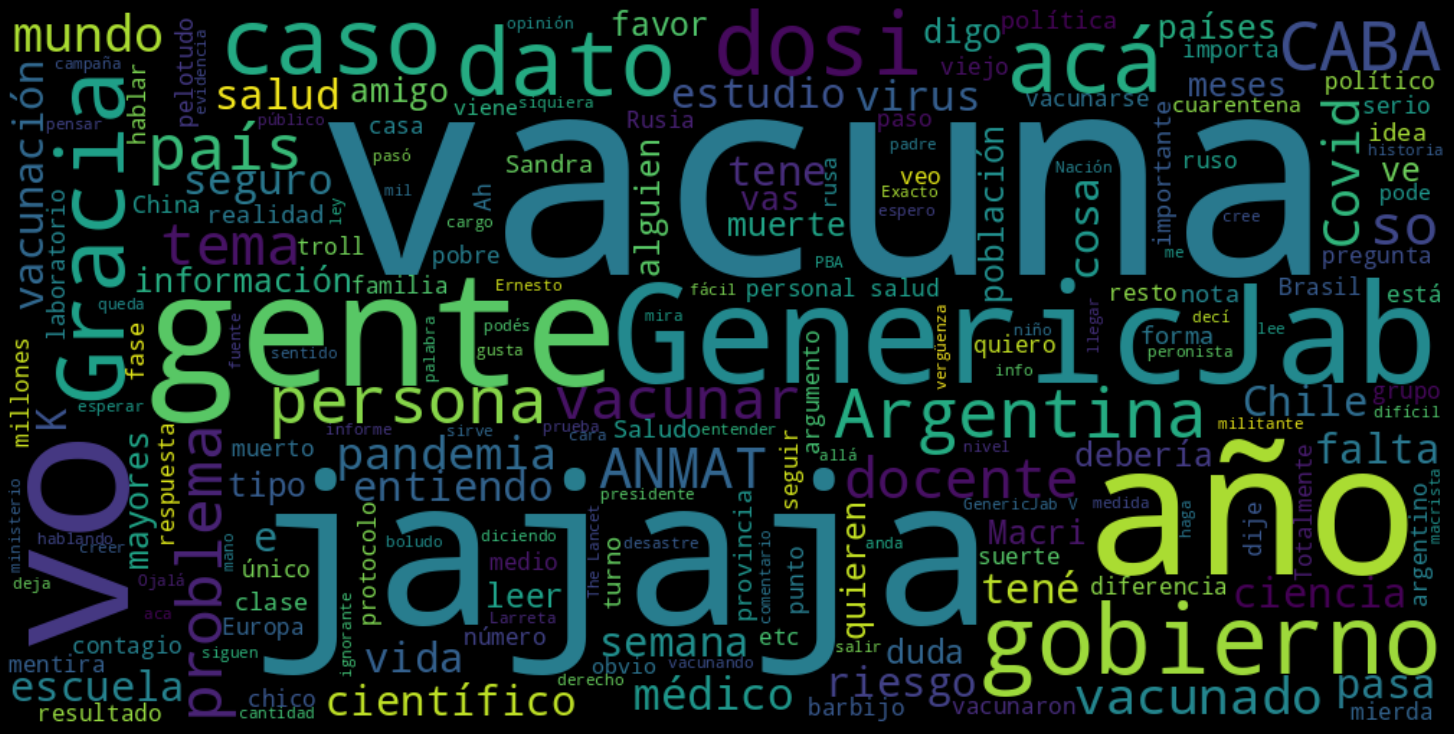

In [6]:
#Nube de palabras Res
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
stop_words = ["y", "o", "a"]

res_text = ' '.join([word for word in new_df["nostop_res"]])
wordcloud = WordCloud(stopwords=stop_words, width = 1000, height=500, background_color="black").generate(res_text)


plt.figure(figsize=(20,10), facecolor='k')
plt.imshow(wordcloud, interpolation="bilinear" )
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig('res_cloud.png', figsize = (1000,500))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later
  if sys.path[0] == '':


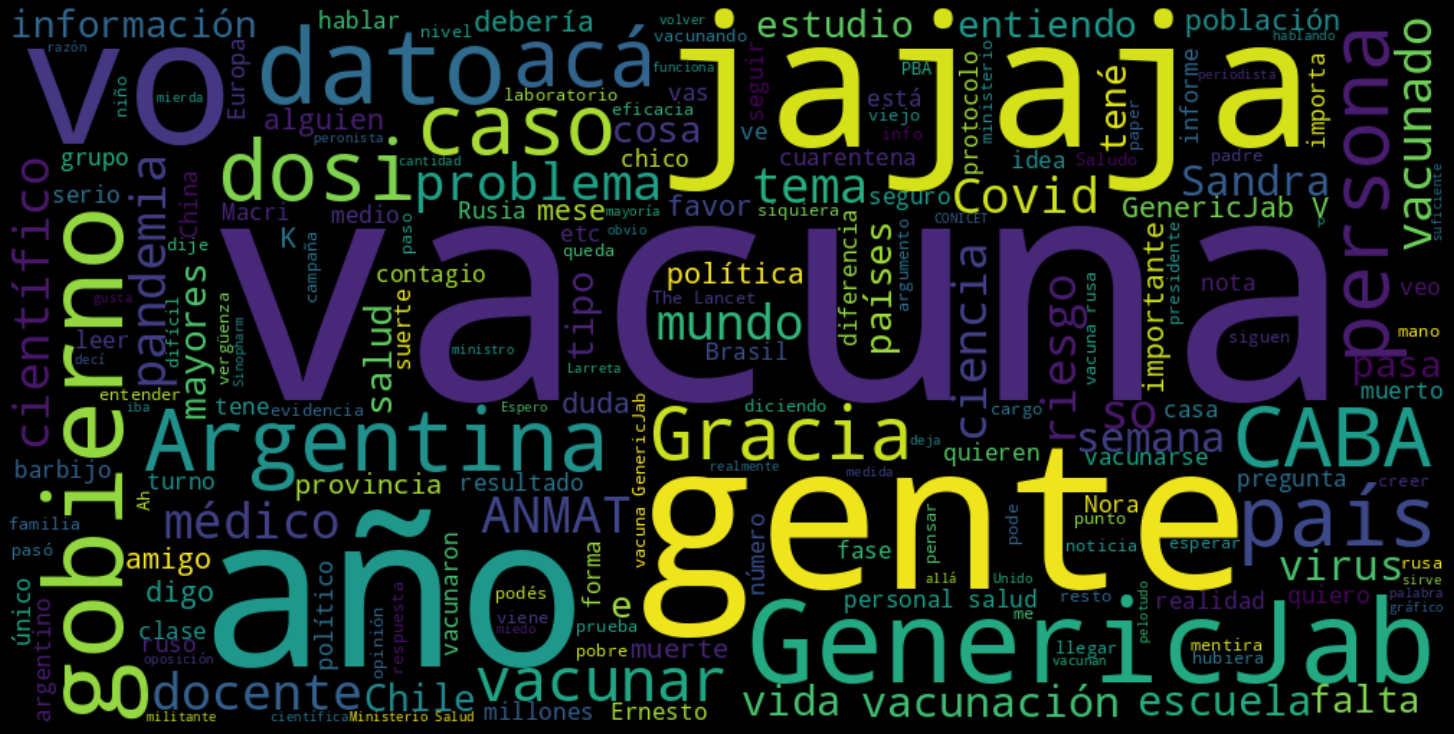

In [7]:
#Nube de palabras OG

og_text = ' '.join([word for word in og_df["nostop_og"]])

wordcloud = WordCloud(stopwords=stop_words,width = 1000, height=500, background_color="black").generate(og_text)


plt.figure(figsize=(20,10), facecolor='k')
plt.imshow(wordcloud, interpolation="bilinear" )
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig('og_cloud.png', figsize = (1000,500))

In [8]:
new_df.to_csv("proc_df.csv")